In [1]:
import numpy as np
from numpy.linalg import norm
from scipy.linalg import expm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib widget

In [2]:
w01 = 2 * np.pi * 5e3
alpha = -350 * 2 * np.pi
nth = 0
gamma1 = 2 * np.pi * 1
gamma_phi = 2 * np.pi * 0.2
kappa = 0
Omegap = 2 * np.pi * 10
Omegas = 2 * np.pi * 0
wp = w01
ws = w01 * 2
g=0

In [3]:
def annihilation_operator(dim: int) -> np.ndarray:
    a = np.zeros((dim, dim), dtype=complex)
    for n in range(1, dim):
        a[n-1, n] = np.sqrt(n)  # <n-1| a |n> = sqrt(n)
    return a

In [4]:
dimq = 3
dimr = 1

Iq = np.eye(dimq)
Ir = np.eye(dimr)
I = np.kron(Iq, Ir)

a_q = annihilation_operator(dimq)
a = np.kron(a_q, Ir)
a_dag = np.kron(a_q.conj().T, Ir)
a_drive = a + a_dag

b_r = annihilation_operator(dimr)
b = np.kron(Iq, b_r)
b_dag = np.kron(Iq, b_r.conj().T)
b_drive = b + b_dag

In [5]:
def H_0(w01: float, alpha: float, wr: float, g:float) -> np.ndarray:
    Hq = w01 * a_dag @ a + (alpha / 2) * a_dag @ a @ (a_dag @ a - I)
    Hr = wr * b_dag @ b
    Hint = g * (a_dag + a) @ (b_dag + b)
    return Hq + Hr + Hint

In [6]:
H0 = H_0(w01, alpha, 0, g)

In [7]:
L_list = [np.sqrt(gamma1 * (1 + nth)) * a, np.sqrt(gamma1 * nth) * a_dag,
          np.sqrt(kappa * (1 + nth)) * b, np.sqrt(kappa * nth) * b_dag, np.sqrt(gamma_phi) * a_dag @ a]
L_norm = [L.conj().T @ L for L in L_list]

In [8]:
J = np.zeros((dimq * dimr, dimq * dimr), dtype=complex)
for L in L_list:
    J += L.conj().T @ L

In [9]:
def H_full(t: float) -> np.ndarray:
    H_drive = Omegap * np.cos(wp * t) * a_drive + Omegas * np.cos(ws * t) * b_drive
    return H0 + H_drive - (1j / 2) * J

In [10]:
He = H0 - 1j / 2 * J
# He = H0

In [78]:
time = np.linspace(0, 1.0, 500000)

In [79]:
dt = time[1] - time[0]

In [80]:
psi_q = np.zeros(dimq, dtype=complex)
psi_q[0] = 1.0
psi_r = np.zeros(dimr, dtype=complex)
psi_r[0] = 1.0

psi0 = np.kron(psi_q, psi_r)


In [81]:
exp = np.exp(1j * wp * time)

In [82]:
num_trajectories = 10

In [ ]:
psi_avg = np.zeros((len(time), dimq * dimr), dtype=complex)
g1  = np.zeros((len(time)//100,len(time)//100), dtype=complex)
for _ in tqdm(range(num_trajectories)):
    psis = np.zeros((len(time), dimq * dimr), dtype=complex)
    a_tr = np.zeros(len(time), dtype=complex)
    psis[0] = psi0
    pl = np.zeros(len(L_list)+1, dtype=float)
    cs = np.zeros(len(time), dtype=int)
    for idx, t in enumerate(time[1:], start=1):
        pump = (np.sin(wp * t) - np.sin(wp * time[idx-1])) * Omegap / wp
        signal = (np.sin(ws * t) - np.sin(ws * time[idx-1])) * Omegas / ws
        U = expm(-1j * (He * dt + pump * a_drive + signal * b_drive ))
        # U = expm(-1j * (He * dt)) @ expm(-1j* pump * a_drive) @ expm(-1j * signal * b_drive )
        # U = dy(t, time[idx-1]).full()
        psi = U @ psis[idx-1]
        L0 = I - 1j * H_full(t) * dt
        # L0 = I - J * dt
        L0n = L0.conj().T @ L0
        pl[0] = np.real(np.vdot(psi, L0n @ psi)) 
        # pl[0] = 0
        for i, Ln in enumerate(L_norm, start=1):
            pl[i] = np.real(np.vdot(psi, Ln @ psi)) * dt
        pl_sum = np.sum(pl)
        if pl_sum <= 0.0:
            print("Warning: non-positive probability sum")
            break
        pl /= pl_sum
        c = np.random.choice(len(pl), p=pl)
        cs[idx] = c
        if c == 0:
            # psi = L0 @ psi
            pass
        else:
            psi = L_list[c-1] @ psi
        psi_norm = norm(psi)
        if psi_norm <= 0:
            print("Warning: zero norm state")
            break
        psis[idx] = psi / psi_norm
        # a_tr[idx] = np.vdot(psis[idx], a @ psis[idx])
    a_tr *= exp
    # g1 += np.outer(a_tr.conj()[::100], a_tr[::100])
    psis *= exp[:, np.newaxis]
    a_psi = np.array([a @ psis[i] for i in range(len(time))])
    # a_psi = a @ psis.T
    g1 += np.array([[np.vdot(a_psi[i], a_psi[j]) for j in range(0, len(time), 100)] for i in range(0, len(time), 100)])
    psi_avg+= psis
psi_avg /= num_trajectories
g1 /= num_trajectories

  0%|          | 0/10 [00:00<?, ?it/s]

In [84]:
t1, t2 = np.meshgrid(time[::100], time[::100], indexing='ij')
tau = t2 - t1
exp_2d = np.exp(1j * wp * tau)
g1_copy = g1 * exp_2d

In [85]:
np.real(g1 - g1_copy).max(), np.real(g1).max()

(np.float64(0.023561098111069573), np.float64(1.0001546458611636))

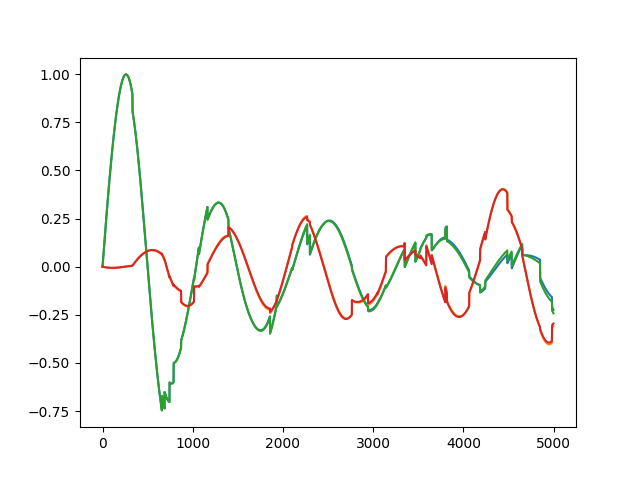

In [86]:
plt.figure()
y = 250
plt.plot(g1.real[:, y])
plt.plot(g1.imag[:, y])
plt.plot(g1_copy.real[:, y])
plt.plot(g1_copy.imag[:, y])

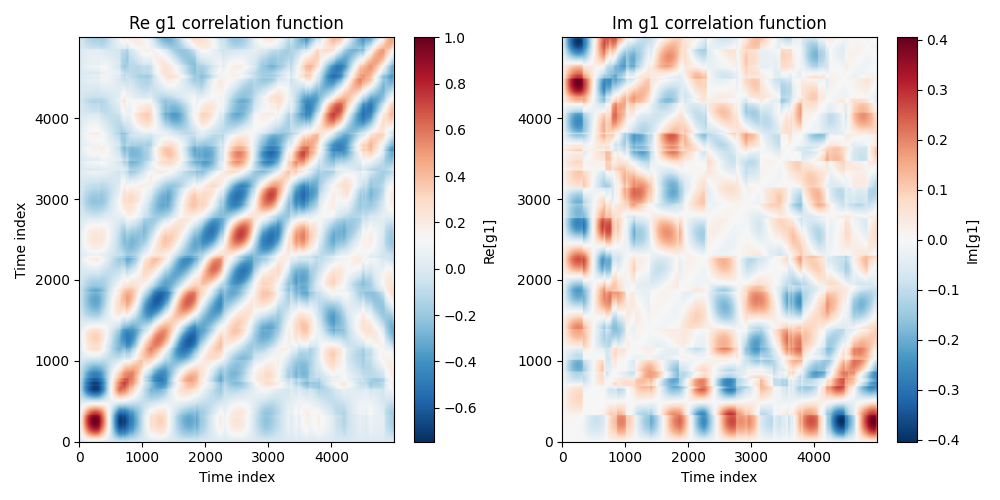

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(np.real(g1), aspect='auto', cmap='RdBu_r', origin='lower')
fig.colorbar(im0, ax=axs[0], label='Re[g1]')
axs[0].set_xlabel('Time index')
axs[0].set_ylabel('Time index')
axs[0].set_title('Re g1 correlation function')

im1 = axs[1].imshow(np.imag(g1), aspect='auto', cmap='RdBu_r', origin='lower')
fig.colorbar(im1, ax=axs[1], label='Im[g1]')
axs[1].set_xlabel('Time index')
axs[1].set_title('Im g1 correlation function')

plt.tight_layout()
plt.show()

In [73]:
g1_spec = np.fft.fftshift(np.fft.fft(g1, axis=0), axes=0)
g1_freqs = np.fft.fftshift(np.fft.fftfreq(g1.shape[0], d=dt*100))

In [66]:
np.max(np.abs(g1_spec))

np.float64(123.9884556956753)

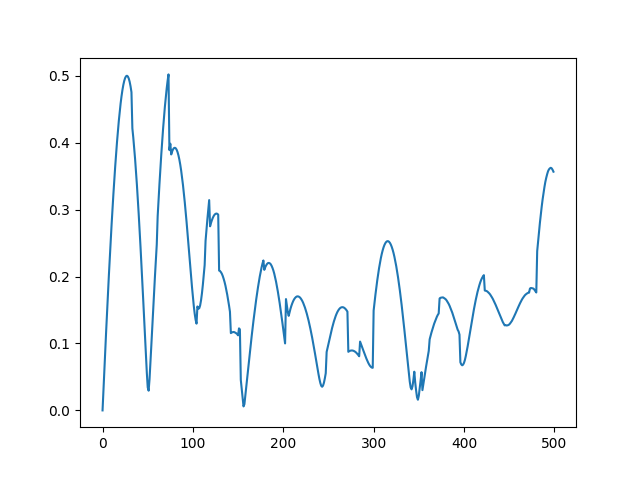

In [67]:
plt.figure()
plt.plot(np.abs(g1_spec[0]))

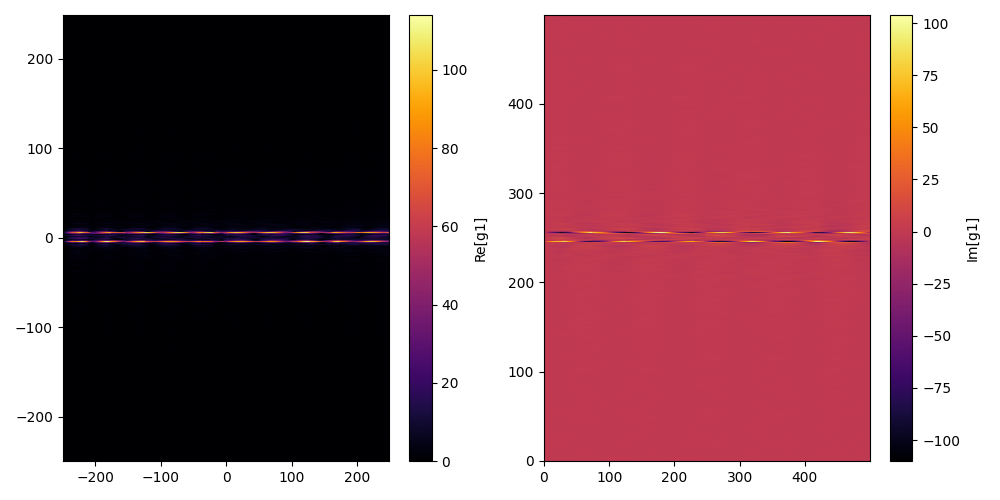

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im0 = axs[0].imshow(np.abs(g1_spec), aspect='auto', cmap='inferno', origin='lower', extent=(g1_freqs[0], g1_freqs[-1], g1_freqs[0], g1_freqs[-1]))
fig.colorbar(im0, ax=axs[0], label='Re[g1]')

im1 = axs[1].imshow(np.imag(g1_spec), aspect='auto', cmap='inferno', origin='lower')
fig.colorbar(im1, ax=axs[1], label='Im[g1]')

plt.tight_layout()
plt.show()

In [39]:
a_mean = np.zeros(len(time), dtype=complex)
n_mean = np.zeros(len(time), dtype=complex)
for idx, psi in enumerate(psi_avg):
    a_mean[idx] = np.vdot(psi, a @ psi)
    n_mean[idx] = np.vdot(psi, a_dag @ a @ psi)

In [21]:
pr0 = [np.vdot(psi_avg[i], psi0) for i in range(len(time))]

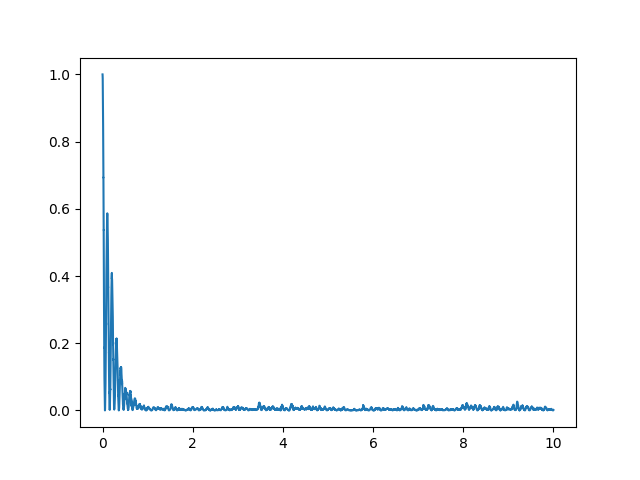

In [22]:
plt.figure()
plt.plot(time, np.abs(pr0)**2)

In [23]:
exp = np.exp(1j * w01 * time)

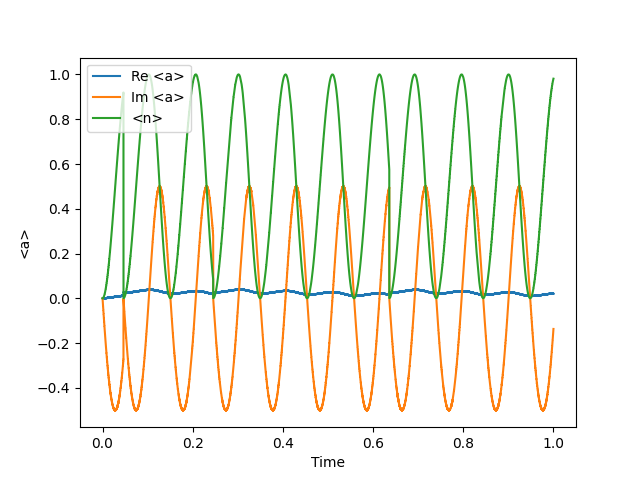

In [41]:
plt.figure()
plt.plot(time, np.real(a_mean * exp), label='Re <a>')
plt.plot(time, np.imag(a_mean*exp), label='Im <a>')
# plt.plot(time, np.abs(a_mean*exp), label='|<a>|')
plt.plot(time, np.real(n_mean), label='<n>')
plt.xlabel('Time')
plt.ylabel('<a>')
plt.legend()
plt.show()


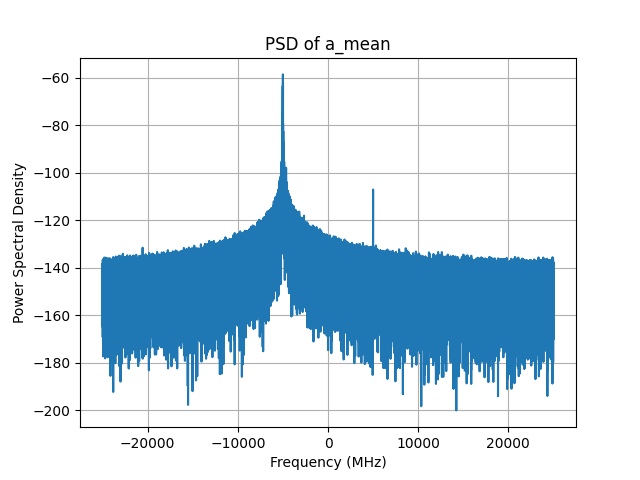

In [25]:
plt.figure()
plt.magnitude_spectrum(a_mean, Fs=1/dt, scale='dB')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density')
plt.title('PSD of a_mean')
plt.grid(True)
plt.show()

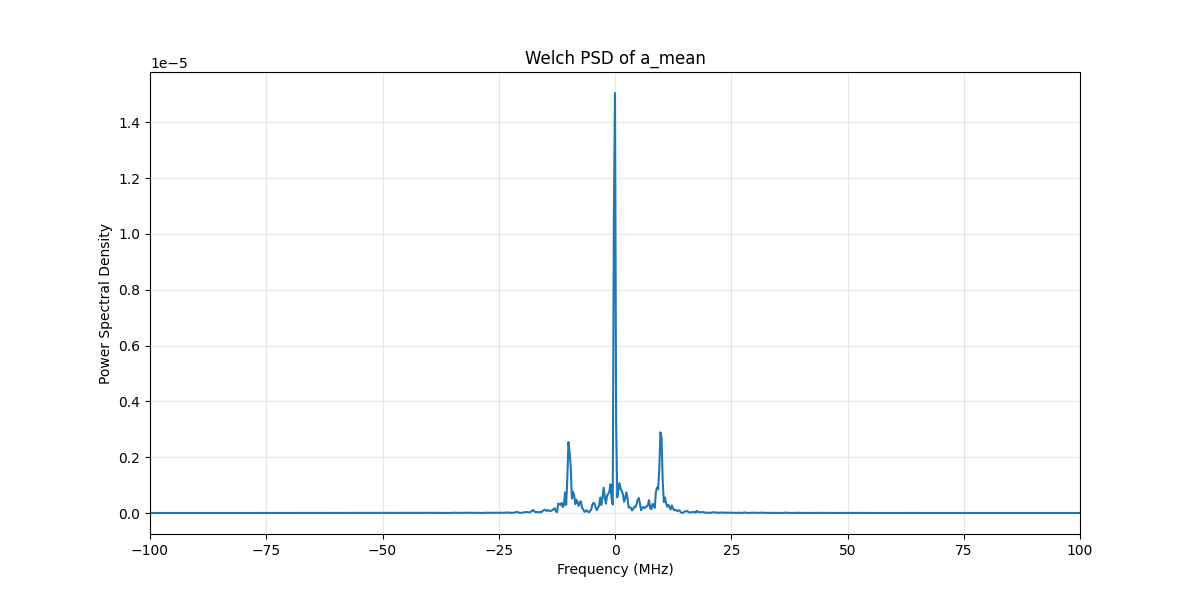

In [26]:
from scipy import signal

# Compute Welch power spectral density
frequencies_welch, psd_welch = signal.welch(a_mean*exp, fs=1/dt, nperseg=40960*5)
fft_values_welch = np.fft.fftshift(frequencies_welch)
psd_welch_shifted = np.fft.fftshift(psd_welch)

# Plot Welch PSD
plt.figure(figsize=(12, 6))
plt.plot(fft_values_welch, psd_welch_shifted)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density')
plt.title('Welch PSD of a_mean')
plt.xlim(-1e2, 1e2)
plt.grid(True, which='both', alpha=0.3)
plt.show()